#### LightFM

Quickstart Example:

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

data = fetch_movielens(min_rating=5.0)
model = LightFM(loss='warp')
model.fit(data['train'], epochs=30, num_threads=2)

precision_at_k(model, data['test'], k=5).mean()

0.051519156

In [3]:
data

{'train': <943x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 19048 stored elements in COOrdinate format>,
 'test': <943x1682 sparse matrix of type '<class 'numpy.int32'>'
 	with 2153 stored elements in COOrdinate format>,
 'item_features': <1682x1682 sparse matrix of type '<class 'numpy.float32'>'
 	with 1682 stored elements in Compressed Sparse Row format>,
 'item_feature_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object),
 'item_labels': array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
        'Sliding Doors (1998)', 'You So Crazy (1994)',
        'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object)}

In [4]:
data['train']

<943x1682 sparse matrix of type '<class 'numpy.float32'>'
	with 19048 stored elements in COOrdinate format>

Not helpful...

### Data

![](images/candy.jpg)

![](images/influenster.png)

### Structure

In [5]:
import pandas as pd

df = pd.read_csv('data/candy.csv')

df.sample(5)

,item,user,review
4166,Ghirardelli Gourmet Milk Sea Salt Escape,lisa27,5
4895,Nestle Baby Ruth Bar,rossstacy,5
11349,Skittles Tropical Candy,lcruz,5
15402,Nestle Baby Ruth Bar,krystal51,5
6073,Brookside Dark Chocolate Acai Blueberry Flavors,freemanchristopher,5


In [6]:
df[df['user'] == 'zjohnson']

,item,user,review
2186,Skittles Sour Candy,zjohnson,5
6022,Haribo Sour Gold Bears Gummi Candy,zjohnson,5
7919,Starburst Original Fruit Chews,zjohnson,5
8382,Sour Patch Watermelon,zjohnson,5
12304,Sour Patch Kids Candy,zjohnson,4


Quick EDA:

In [7]:
df['item'].value_counts()[:5]

Twix                                       340
Snickers Chocolate Bar                     330
Werther's Original Caramel Hard Candies    322
M&Ms Peanut Chocolate Candy                310
M&Ms Milk Chocolate Candy                  273
Name: item, dtype: int64

In [8]:
df['item'].unique().shape

(142,)

In [9]:
df['user'].unique().shape

(2531,)

In [10]:
df['review'].value_counts()

5    12977
4     2554
3      967
2      372
1      364
Name: review, dtype: int64

In [11]:
df.groupby('user')['item'].count().mean()

6.809166337416041

Back to `data['train']`...

In [12]:
data['train']

<943x1682 sparse matrix of type '<class 'numpy.float32'>'
	with 19048 stored elements in COOrdinate format>

In [13]:
data['train'].todense()

matrix([[5., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [5., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 5., 0., ..., 0., 0., 0.]], dtype=float32)

In [14]:
data['item_labels']

array(['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', ...,
       'Sliding Doors (1998)', 'You So Crazy (1994)',
       'Scream of Stone (Schrei aus Stein) (1991)'], dtype=object)

### Sparsity

Data needs to look like this:

In [15]:
ex = pd.DataFrame([
    [0, 1, 1, 0, 0, 0],
    [0, 1, 1, 1, 0, 0],
    [1, 0, 0, 1, 0, 0],
    [0, 1, 1, 0, 0, 1],
    [0, 0, 0, 1, 1, 1]], 
    columns=['twix', 'mars', 'reeses', 'skittles', 'snickers', 'lindt'])

ex

,twix,mars,reeses,skittles,snickers,lindt
0,0,1,1,0,0,0
1,0,1,1,1,0,0
2,1,0,0,1,0,0
3,0,1,1,0,0,1
4,0,0,0,1,1,1


In [16]:
r, c = ex.shape
ex.sum().sum() / (r * c)

0.43333333333333335

In [17]:
import sys

sys.getsizeof(ex)

400

In [18]:
ex.values

array([[0, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0],
       [1, 0, 0, 1, 0, 0],
       [0, 1, 1, 0, 0, 1],
       [0, 0, 0, 1, 1, 1]])

In [19]:
import scipy.sparse as sp

sx = sp.coo_matrix(ex.values)

In [20]:
sys.getsizeof(sx)

64

The Movielens situation:

In [21]:
movie_lens = pd.DataFrame(data['train'].todense(), columns=data['item_labels'])

In [22]:
movie_lens.head()

,Toy Story (1995),GoldenEye (1995),Four Rooms (1995),Get Shorty (1995),Copycat (1995),Shanghai Triad (Yao a yao yao dao waipo qiao) (1995),Twelve Monkeys (1995),Babe (1995),Dead Man Walking (1995),Richard III (1995),...,Mirage (1995),Mamma Roma (1962),"Sunchaser, The (1996)","War at Home, The (1996)",Sweet Nothing (1995),Mat' i syn (1997),B. Monkey (1998),Sliding Doors (1998),You So Crazy (1994),Scream of Stone (Schrei aus Stein) (1991)
0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
sys.getsizeof(movie_lens)

6344664

In [24]:
sys.getsizeof(data['train'])

64

### Sparse Candy

Making candy look like Movielens

In [25]:
df.sample(5)

,item,user,review
12339,York Peppermint Patty,lonnie84,5
1875,Milky Way Candy Bar,isuarez,5
2419,Hershey's Natural Unsweetened Cocoa,juliewallace,5
13419,Reese's Peanut Butter Egg,david52,5
16340,Haribo Sour Gold Bears Gummi Candy,gregory06,5


In [26]:
# don't do this!

df.pivot_table(index='user', columns='item', values='review').fillna(0)

item,3 Musketeers Candy Bar,3 Musketeers Miniature Bars,5 Gum,Airheads Bites Fruit,Airheads White Mystery,Airheads Xtremes Sweetly Sour Candy Rainbow Berry,Almond Joy Snack Size Bites,Altoids Curiously Strong Cinnamon Mints,Bouquet of Fruits Valentine Chocolate Dipped Strawberries,Brachs Candy Corn,...,Trolli Sour Brite Crawlers,Trolli Sour Brite Eggs Candy,Twix,Twix Bites,Twizzlers Bites Cherry Gummy Candy,Twizzlers Pull-N-Peel Candy Cherry,Twizzlers Twists Strawberry,Warheads Extreme Sour Hard Candy,Werther's Original Caramel Hard Candies,York Peppermint Patty
user,,,,,,,,,,,,,,,,,,,,,
aaron67,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron73,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abarker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abigail04,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zsellers,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
zsimpson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
zsmith,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
from scipy.sparse import coo_matrix

help(coo_matrix)

Help on class coo_matrix in module scipy.sparse.coo:

class coo_matrix(scipy.sparse.data._data_matrix, scipy.sparse.data._minmax_mixin)
 |  coo_matrix(arg1, shape=None, dtype=None, copy=False)
 |  
 |  A sparse matrix in COOrdinate format.
 |  
 |  Also known as the 'ijv' or 'triplet' format.
 |  
 |  This can be instantiated in several ways:
 |      coo_matrix(D)
 |          with a dense matrix D
 |  
 |      coo_matrix(S)
 |          with another sparse matrix S (equivalent to S.tocoo())
 |  
 |      coo_matrix((M, N), [dtype])
 |          to construct an empty matrix with shape (M, N)
 |          dtype is optional, defaulting to dtype='d'.
 |  
 |      coo_matrix((data, (i, j)), [shape=(M, N)])
 |          to construct from three arrays:
 |              1. data[:]   the entries of the matrix, in any order
 |              2. i[:]      the row indices of the matrix entries
 |              3. j[:]      the column indices of the matrix entries
 |  
 |          Where ``A[i[k], j[k]] = da

In [28]:
import numpy as np

In [29]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])

sp.coo_matrix((data, (row, col)), shape=(3, 3)).toarray()

array([[1, 0, 2],
       [0, 0, 3],
       [4, 5, 6]])

In [30]:
ratings = 'review'
users = 'user'
items = 'item'

ratings = np.array(df[ratings])
users = np.array(df[users])
items = np.array(df[items])

In [31]:
users

array(['darlene90', 'taylordarlene', 'aliciadennis', ..., 'powellmegan',
       'benjaminjohnson', 'xrichards'], dtype=object)

In [32]:
items

array(["Reese's Peanut Butter Cups Miniatures",
       "Reese's Peanut Butter Cups Miniatures",
       "Reese's Peanut Butter Cups Miniatures", ...,
       "Hershey's Nuggets Chocolate Assortment",
       "Hershey's Nuggets Chocolate Assortment",
       "Hershey's Nuggets Chocolate Assortment"], dtype=object)

In [33]:
ratings

array([5, 4, 5, ..., 5, 5, 5])

### First Try

In [34]:
sp.coo_matrix((ratings, (users, items)), shape=(len(users), len(items)))

ValueError: invalid literal for int() with base 10: 'darlene90'

### Second Try

"Everything needs to be a number"

In [39]:
from sklearn.preprocessing import LabelEncoder

# heavy lifting encoders
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

# preparation for the csr matrix
u = user_encoder.fit_transform(users)
i = item_encoder.fit_transform(items)
lu = len(np.unique(u))
li = len(np.unique(i))

In [40]:
matrix = sp.coo_matrix((ratings, (u, i)), shape=(lu, li))

In [41]:
matrix

<2531x142 sparse matrix of type '<class 'numpy.int64'>'
	with 17234 stored elements in COOrdinate format>

In [42]:
# don't do this...

matrix.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 5],
        [0, 0, 0, ..., 0, 0, 5]])

In [43]:
item_encoder.classes_[:10]

array(['3 Musketeers Candy Bar', '3 Musketeers Miniature Bars', '5 Gum',
       'Airheads Bites Fruit', 'Airheads White Mystery',
       'Airheads Xtremes Sweetly Sour Candy Rainbow Berry',
       'Almond Joy Snack Size Bites',
       'Altoids Curiously Strong Cinnamon Mints',
       'Bouquet of Fruits Valentine Chocolate Dipped Strawberries',
       'Brachs Candy Corn'], dtype=object)

### Interaction Machine

In [44]:
import scipy.sparse as ss

class Interactions:
    def __init__(self):
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()

    def __repr__(self):
        return 'InteractionMachine()'

    def fit(self, users, items):
        self.user_encoder.fit(users)
        self.item_encoder.fit(items)
        return self
    
    def transform(self, users, items, ratings):
        u = self.user_encoder.transform(users)
        i = self.item_encoder.transform(items)
        self.n_users = len(np.unique(u))
        self.n_items = len(np.unique(i))
        interactions = ss.coo_matrix((ratings, (u, i)), shape=(self.n_users, self.n_items))
        return interactions

In [45]:
interactions = Interactions()

interactions.fit(df['user'], df['item'])

matrix = interactions.transform(df['user'], df['item'], df['review'])

In [46]:
matrix.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 5],
       [0, 0, 0, ..., 0, 0, 5]])

### Basic LightFM 

In [47]:
model = LightFM()

In [48]:
model.fit(matrix)

In [49]:
model.predict(matrix) # not exactly sklearn...

TypeError: predict() missing 1 required positional argument: 'item_ids'

In [50]:
interactions.user_encoder.transform(['zsmith'])

array([2528])

In [51]:
interactions.item_encoder.classes_[:10]

array(['3 Musketeers Candy Bar', '3 Musketeers Miniature Bars', '5 Gum',
       'Airheads Bites Fruit', 'Airheads White Mystery',
       'Airheads Xtremes Sweetly Sour Candy Rainbow Berry',
       'Almond Joy Snack Size Bites',
       'Altoids Curiously Strong Cinnamon Mints',
       'Bouquet of Fruits Valentine Chocolate Dipped Strawberries',
       'Brachs Candy Corn'], dtype=object)

In [52]:
interactions.item_encoder.transform(['M&Ms Peanut Chocolate Candy'])

array([74])

In [53]:
interactions.item_encoder.transform(['Skittles Sour Candy'])

array([103])

In [54]:
interactions.item_encoder.transform(['Juicy Fruit Gum'])

array([55])

In [55]:
model.predict(2528, [74, 103, 55])

array([1.44223356, 1.25621653, 0.88986391])

In [56]:
model.predict(2528, np.arange(len(interactions.item_encoder.classes_)))

array([1.31159329, 0.6209389 , 1.02252471, 0.72635013, 1.23071635,
       1.17377794, 1.09210217, 0.45929852, 1.02759492, 1.05904114,
       0.67169517, 0.61320484, 1.09749269, 0.74918532, 0.6531139 ,
       0.53257447, 1.31680584, 0.82592136, 0.71155345, 1.07567704,
       0.71157116, 0.80172181, 0.71075636, 0.71527517, 0.95627046,
       1.08366621, 1.2205478 , 0.49388972, 1.10939515, 0.64056385,
       0.50951999, 0.97066283, 0.88221091, 0.96607131, 0.60847855,
       0.82293928, 1.16857338, 1.21944284, 0.80703837, 1.34118557,
       1.19427955, 1.13830769, 0.70541507, 1.18433678, 0.83397281,
       1.13187897, 1.04730976, 0.98387456, 1.18398798, 1.20715368,
       0.85053164, 0.72346246, 0.83033299, 1.33906412, 0.8378371 ,
       0.88986391, 0.59157723, 0.62979698, 0.88863927, 0.99423915,
       0.94539988, 0.68808478, 0.94564003, 1.10854435, 1.08803105,
       1.22366476, 0.97963804, 0.99490607, 0.54826367, 0.25001541,
       0.65379351, 1.15952075, 1.37042475, 0.67135888, 1.44223

In [57]:
pd.DataFrame({
    'item': interactions.item_encoder.classes_, 
    'pred': model.predict(2528, np.arange(len(interactions.item_encoder.classes_)))
}).sort_values('pred', ascending=False).head(10)

,item,pred
134,Twix,1.496954
108,Snickers Chocolate Bar,1.481998
140,Werther's Original Caramel Hard Candies,1.466759
74,M&Ms Peanut Chocolate Candy,1.442234
72,M&Ms Milk Chocolate Candy,1.370425
39,Hershey's Kisses Milk Chocolate,1.341186
53,Jolly Rancher Hard Candy Original Flavors Asso...,1.339064
16,Creme Savers Strawberries Rolls,1.316806
0,3 Musketeers Candy Bar,1.311593
141,York Peppermint Patty,1.266354


In [58]:
df[df['user'] == 'zsmith']

,item,user,review
3352,Twix Bites,zsmith,5
4563,Pez Candy,zsmith,5
5922,Nestle Butterfinger Bites,zsmith,5
8273,M&Ms Brand Peanut Butter Chocolate Candies Hol...,zsmith,5
9538,Life Savers Five Flavor Gummies,zsmith,1
10021,Nestle Toll House Ultimatestm Chocolate Chip L...,zsmith,5
10562,Jolly Rancher Hard Candy Original Flavors Asso...,zsmith,5
11066,Brookside Dark Chocolate Pomegranate Flavor,zsmith,5
14998,Hershey's Halloween Snack Size Assortment,zsmith,5
16937,Kit Kat Big Kat King Size Wafer Bar,zsmith,5


### Evaluation

In [59]:
from lightfm.evaluation import auc_score, precision_at_k

> AUC measures the quality of the overall ranking. In the binary case, it can be interpreted as the probability that a randomly chosen positive item is ranked higher than a randomly chosen negative item. Consequently, an AUC close to 1.0 will suggest that, by and large, your ordering is correct: and this can be true even if none of the first K items are positives. This metric may be more appropriate if you do not exert full control on which results will be presented to the user; it may be that the first K recommended items are not available any more (say, they are out of stock), and you need to move further down the ranking. A high AUC score will then give you confidence that your ranking is of high quality throughout.

[Source](https://stackoverflow.com/questions/45451161/evaluating-the-lightfm-recommendation-model)

> Precision@K measures the proportion of positive items among the K highest-ranked items. As such, it's very focused on the ranking quality at the top of the list: it doesn't matter how good or bad the rest of your ranking is as long as the first K items are mostly positive. This would be an appropriate metric if you are only ever going to be showing your users the very top of the list.

[Source](https://stackoverflow.com/questions/45451161/evaluating-the-lightfm-recommendation-model)

In [60]:
auc_score(model, matrix).mean()

0.6517898

In [61]:
precision_at_k(model, matrix, k=10).mean()

0.1109838

### train-test-split

In [62]:
# don't do this...
from sklearn.model_selection import train_test_split

In [63]:
train_test_split(matrix)
# because...

[<1898x142 sparse matrix of type '<class 'numpy.float32'>'
 	with 12890 stored elements in Compressed Sparse Row format>,
 <633x142 sparse matrix of type '<class 'numpy.float32'>'
 	with 4309 stored elements in Compressed Sparse Row format>]

### Traditional 

![](images/tts_traditional.png)

### Recommendation

![](images/tts_reco.png)

In [64]:
# do this
from lightfm.cross_validation import random_train_test_split

In [65]:
train, test = random_train_test_split(matrix, test_percentage=0.2)

In [66]:
train

<2531x142 sparse matrix of type '<class 'numpy.float32'>'
	with 13787 stored elements in COOrdinate format>

In [67]:
test

<2531x142 sparse matrix of type '<class 'numpy.float32'>'
	with 3447 stored elements in COOrdinate format>

### Training Cycle

In [68]:
model = LightFM()
model.fit(train, epochs=500)

In [69]:
auc_score(model, test).mean()

0.66526586

In [70]:
model = LightFM()

scores = []
for e in range(100):
    model.fit_partial(train, epochs=1)
    auc_train = auc_score(model, train).mean()
    auc_test = auc_score(model, test).mean()
    scores.append((auc_train, auc_test))
    
scores = np.array(scores)

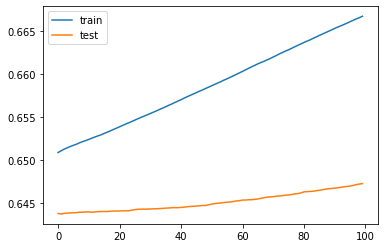

In [71]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.plot(scores[:, 0], label='train')
plt.plot(scores[:, 1], label='test')
plt.legend()

### Loss

> WARP: Weighted Approximate-Rank Pairwise loss. Maximises
  the rank of positive examples by repeatedly sampling negative
  examples until rank violating one is found. Useful when only
  positive interactions are present and optimising the top of
  the recommendation list (precision@k) is desired.

In [72]:
model = LightFM(loss='warp')

scores = []
for e in range(100):
    model.fit_partial(train, epochs=1)
    auc_train = auc_score(model, train).mean()
    auc_test = auc_score(model, test).mean()
    scores.append((auc_train, auc_test))
    
scores = np.array(scores)

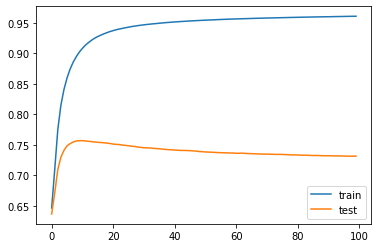

In [73]:
from matplotlib import pyplot as plt

plt.plot(scores[:, 0], label='train')
plt.plot(scores[:, 1], label='test')
plt.legend()

### Activity

Take 5 minutes to explore different epoch and loss combinations

### Early Stopping

In [74]:
from copy import deepcopy

model = LightFM(loss='warp')

count = 0
best = 0
scores = []
for e in range(100):
    if count > 5: # patience
        break
    model.fit_partial(train, epochs=1)
    auc_train = auc_score(model, train).mean()
    auc_test = auc_score(model, test).mean()
    print(f'Epoch: {e}, Train AUC={auc_train:.3f}, Test AUC={auc_test:.3f}')
    scores.append((auc_train, auc_test))
    if auc_test > best:
        best_model = deepcopy(model)
        best = auc_test
    else:
        count += 1

model = deepcopy(best_model)

Epoch: 0, Train AUC=0.641, Test AUC=0.627
Epoch: 1, Train AUC=0.708, Test AUC=0.668
Epoch: 2, Train AUC=0.775, Test AUC=0.710
Epoch: 3, Train AUC=0.814, Test AUC=0.731
Epoch: 4, Train AUC=0.839, Test AUC=0.741
Epoch: 5, Train AUC=0.858, Test AUC=0.748
Epoch: 6, Train AUC=0.872, Test AUC=0.751
Epoch: 7, Train AUC=0.883, Test AUC=0.753
Epoch: 8, Train AUC=0.891, Test AUC=0.754
Epoch: 9, Train AUC=0.899, Test AUC=0.754
Epoch: 10, Train AUC=0.906, Test AUC=0.754
Epoch: 11, Train AUC=0.911, Test AUC=0.754
Epoch: 12, Train AUC=0.915, Test AUC=0.754
Epoch: 13, Train AUC=0.919, Test AUC=0.753
Epoch: 14, Train AUC=0.922, Test AUC=0.753
Epoch: 15, Train AUC=0.925, Test AUC=0.752
Epoch: 16, Train AUC=0.928, Test AUC=0.752


### New Predictions

In [75]:
user = 'aaron67'
df[df['user'] == user]

,item,user,review
13806,Mike and Ike Sour Licious Zours,aaron67,4
14073,Kit Kat Minis Crisp Wafers in Milk Chocolate,aaron67,5
14396,Reese's Peanut Butter Cup Pumpkins Milk Chocolate,aaron67,5
15153,Snickers Crisper Chocolate Bar,aaron67,1
15296,Snickers Peanut Butter Squared Bars,aaron67,5
16867,Reese's Peanut Butter Heart,aaron67,5


In [76]:
interactions.user_encoder.transform([user])[0]

0

In [77]:
user_id = interactions.user_encoder.transform([user])[0]

In [78]:
preds = model.predict(user_id, list(range(interactions.n_items)))
preds = pd.DataFrame(zip(preds, interactions.item_encoder.classes_), columns=['pred', 'item'])
preds = preds.sort_values('pred', ascending=False)
preds.head()

,pred,item
140,0.330497,Werther's Original Caramel Hard Candies
108,0.101706,Snickers Chocolate Bar
43,0.098795,Hershey's Natural Unsweetened Cocoa
0,0.054062,3 Musketeers Candy Bar
134,0.012440,Twix


In [79]:
tried = df[df['user'] == user]['item'].values
list(preds[~preds['item'].isin(tried)]['item'].values[:5])

["Werther's Original Caramel Hard Candies",
 'Snickers Chocolate Bar',
 "Hershey's Natural Unsweetened Cocoa",
 '3 Musketeers Candy Bar',
 'Twix']